In [1]:
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime as dt
from shapely import wkt
from shapely.geometry import Point, Polygon
import geopandas as gpd
import rtree, pygeos, fiona
import netCDF4
import xarray as xr
import dask

/Users/etriesch/.pyenv/versions/venv.ocean-carbon-sampling/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
repo_path = Path('/Users/etriesch/dev/ocean-carbon-sampling/')
data_raw_path = repo_path / 'data/raw/'
data_clean_path = repo_path / 'data/clean/'
geo_crs = 'epsg:4326'

In [3]:
# Northeast Pacific mask
p_min_lat, p_max_lat = 29, 48
p_min_lon, p_max_lon = -140, -116
p_min_y, p_max_y = 996, 1460
p_min_x, p_max_x = 940, 1832
#Northwest Atlantic mask
a_min_lat, a_max_lat = 20, 48
a_min_lon, a_max_lon = -97, -60
a_min_y, a_max_y = 996, 1675
a_min_x, a_max_x = 1960, 2884
# Monterrey desal mask
ca_min_lat, ca_max_lat = 33.48, 39.48
ca_min_lon, ca_max_lon = -125.48, -119.48
# Texas desal mask
tx_min_lat, tx_max_lat = 25.57, 31.57
tx_min_lon, tx_max_lon = -98.21, -92.21
# NH desal mask
nh_min_lat, nh_max_lat = 39.38, 45.38
nh_min_lon, nh_max_lon = -73.50, -67.50

# Read in data

In [4]:
# get filenames
color_path = repo_path / 'data/raw/color/'
c_files = [f for f in os.listdir(color_path) 
           if f.endswith('.nc')]
c_files.sort()
print('files to read:', len(c_files))

files to read: 72


In [5]:
# read in data
chl_pac = pd.DataFrame()
chl_atl = pd.DataFrame()
for f in tqdm(c_files[0:12]):
# for f in tqdm(c_files):
    c = xr.open_dataset(color_path / f)
    # reset lat/lon
    c['lat'] = c.lat.to_dataframe().reset_index(drop=True).index
    c['lon'] = c.lon.to_dataframe().reset_index(drop=True).index
    # create pacific and atlantic masks
    p_mask_lon = (c.lon >= p_min_x) & (c.lon <= p_max_x)
    p_mask_lat = (c.lat >= p_min_y) & (c.lat <= p_max_y)
    a_mask_lon = (c.lon >= a_min_x) & (c.lon <= a_max_x)
    a_mask_lat = (c.lat >= a_min_y) & (c.lat <= a_max_y)
    c_pac = c.where(p_mask_lon & p_mask_lat, drop=True)
    c_atl = c.where(a_mask_lon & a_mask_lat, drop=True)
    # convert to dataset and append
    c_pac = c_pac.chlor_a.to_dataframe().reset_index()
    c_pac['date_string'] = f[1:14]
    c_atl = c_atl.chlor_a.to_dataframe().reset_index()
    c_atl['date_string'] = f[1:14]
    chl_pac = pd.concat([c_pac, chl_pac])
    chl_atl = pd.concat([c_atl, chl_atl])

100%|███████████████████████████████████████████| 72/72 [06:02<00:00,  5.03s/it]


# Clean and subset

In [55]:
# make single df for cleaning
chl_pac['pacific'] = True
chl_atl['pacific'] = False
chl_raw = pd.concat([chl_pac, chl_atl]).reset_index(drop=True)

In [56]:
chl_raw = chl_raw.rename(columns={'lat':'x', 'lon':'y'})
chl_raw['date'] = pd.to_datetime(chl_raw.date_string.str[0:7], format='%Y%j')
chl_raw['year'] = chl_raw.date.dt.year

In [57]:
# clean chlorophyl values
# set outlier as 5 times the 75th percentile
pctl, outl = 0.75, 5
pctl_colname = 'pctl'+str(int(pctl*100))
chl_raw[pctl_colname] = chl_raw.groupby(['year', 'pacific'])['chlor_a'].transform(lambda x: x.quantile(pctl))
chl_raw['drop_outlier'] = chl_raw.chlor_a >= outl * chl_raw[pctl_colname]
print(f'Outliers dropped (Pacific): {chl_raw.loc[chl_raw.pacific & chl_raw.drop_outlier].shape[0]} ({chl_raw.loc[chl_raw.pacific & chl_raw.drop_outlier].shape[0] / chl_raw.loc[chl_raw.pacific].shape[0]:0.2%})')
print(f'Outliers dropped (Atlantic): {chl_raw.loc[~chl_raw.pacific & chl_raw.drop_outlier].shape[0]} ({chl_raw.loc[~chl_raw.pacific & chl_raw.drop_outlier].shape[0] / chl_raw.loc[~chl_raw.pacific].shape[0]:0.2%})')

Outliers dropped (Pacific): 407969 (1.36%)
Outliers dropped (Atlantic): 1774285 (3.92%)


In [58]:
# drop outliers
chl_raw = chl_raw.loc[~chl_raw.drop_outlier]

In [59]:
# drop any point that doesn't have more than N observations in a year
# get mean, max, std chlorophyll per year at each location
OBS_THRESHOLD = 1
chl_raw['drop_low_annual_count'] = chl_raw.groupby(['pacific', 'x', 'y', 'year'])['chlor_a'].transform('count') < OBS_THRESHOLD
print(f'Low annual count dropped (Pacific): {chl_raw.loc[chl_raw.pacific & chl_raw.drop_low_annual_count].shape[0]} ({chl_raw.loc[chl_raw.pacific & chl_raw.drop_low_annual_count].shape[0] / chl_raw.loc[chl_raw.pacific].shape[0]:0.2%})')
print(f'Low annual count dropped (Atlantic): {chl_raw.loc[~chl_raw.pacific & chl_raw.drop_low_annual_count].shape[0]} ({chl_raw.loc[~chl_raw.pacific & chl_raw.drop_low_annual_count].shape[0] / chl_raw.loc[~chl_raw.pacific].shape[0]:0.2%})')

Low annual count dropped (Pacific): 14264437 (48.37%)
Low annual count dropped (Atlantic): 19923058 (45.79%)


In [73]:
# drop missing obs
# chl = chl_raw.loc[~chl_raw.drop_low_annual_count].reset_index(drop=True)
chl = chl_raw

### Interpolate missing values linearly

In [74]:
# generate date range for each latitude
chl_date_range = chl.date.agg(['min','max'])
dates = pd.DataFrame({'date': pd.date_range(chl_date_range[0], chl_date_range[1], freq='MS')})
dates['tmp'] = 1
latlons = chl.groupby(['pacific', 'x', 'y'])['date'].agg(['min','max']).reset_index()
latlons['tmp'] = 1
dates_pac = pd.merge(left=latlons.loc[latlons.pacific], right=dates, how='left', on=['tmp'])
dates_pac = dates_pac.loc[(dates_pac.date >= dates_pac['min']) & (dates_pac.date <= dates_pac['max'])] #subset to appropriate date range
dates_atl = pd.merge(left=latlons.loc[~latlons.pacific], right=dates, how='left', on=['tmp'])
dates_atl = dates_atl.loc[(dates_atl.date >= dates_atl['min']) & (dates_atl.date <= dates_atl['max'])] #subset to appropriate date range
dates = pd.concat([dates_pac, dates_atl]).reset_index(drop=True)

In [75]:
# merge in missing dates
chl = pd.merge(left=chl, right=dates, how='right', on=['pacific', 'x', 'y', 'date'])
chl['int'] = chl.chlor_a.isna()
print(f'interpolating {chl.int.sum()} months out of {chl.shape[0]}, ({(chl.int.sum())/chl.shape[0]: 0.2%})')

interpolating 37837100 months out of 74576837, ( 50.74%)


In [76]:
# linear interpolation of points: sort values, interpolate linearly
chl = chl.sort_values(['pacific', 'x', 'y', 'date']).reset_index(drop=True)
chl['chlor_a_int'] = chl.chlor_a.interpolate(method='linear')
chl['chlor_a_cln'] = np.where(chl.int, chl.chlor_a_int, chl.chlor_a)
# replace with nan if data from previous group
chl['count'] = chl.groupby(['x', 'y']).cumcount()
chl['chlor_a_cln'] = np.where((chl['count'] == 0) & (chl.int), np.nan, chl.chlor_a_cln)

In [77]:
chl = chl[['pacific', 'x', 'y', 'date', 'chlor_a_cln', 'int']]
chl['year'] = chl.date.dt.year

# Create analytical columns

In [78]:
# get mean, max, std chlorophyll per year at each location
chl_s = chl.groupby(['pacific', 'x', 'y', 'year'])['chlor_a_cln'].agg(['count', 'std', 'max', 'mean']).reset_index()
# drop any half years
OBS_THRESHOLD = 4
print(f"Dropping {(chl_s['count'] < OBS_THRESHOLD).sum()} ({(chl_s['count']<OBS_THRESHOLD).sum()/chl_s.shape[0]:0.2%}) point-years that have less than {OBS_THRESHOLD} months of data (including interpolation)")
chl_s = chl_s.loc[chl_s['count'] >= OBS_THRESHOLD]

Dropping 7190 (0.12%) point-years that have less than 4 months of data (including interpolation)


In [79]:
# merge back onto full dataset
chl_m = pd.merge(left=chl, right=chl_s, how='right', on=['pacific', 'x', 'y', 'year'])

In [80]:
# flag values lower than mean
chl_m['below_mean'] = chl_m['chlor_a_cln'] < chl_m['mean']
# lag 1 and flag if first month below
chl_m['drop_below_mean'] = chl_m['below_mean'] & ~chl_m.groupby(['x', 'y'])['below_mean'].shift(1).fillna(True)
# get building blocks for max time below mean
chl_m['crossing'] = (chl_m['below_mean'] != chl_m.groupby(['x', 'y', 'year'])['below_mean'].shift(1).fillna(True)).cumsum()
chl_m['months_below_mean'] = chl_m.groupby(['x', 'y', 'year', 'below_mean', 'crossing']).cumcount(ascending=False) + 1

chl_m.loc[~chl_m.below_mean, 'months_below_mean'] = 0

# summarize number of months below per year, number of drops below per year
chl_m_s = (chl_m
          .groupby(['pacific', 'x', 'y', 'year'])[['below_mean', 'drop_below_mean', 'months_below_mean']]
          .agg({'below_mean':'sum', 'drop_below_mean':'sum', 'months_below_mean':'max'}).reset_index())
chl_m_s['bimodal_chl'] = chl_m_s['below_mean'] - chl_m_s['months_below_mean']


KeyboardInterrupt



# Combine analysis datasets

In [ ]:
print('Stats summary:', chl_m_s.shape[0])
print('Months summary:', chl_s.shape[0])
chl_summ_annual = pd.merge(left=chl_s, right=chl_m_s, on=['pacific', 'x', 'y', 'year'], how='outer')
print('Merged data:', chl_summ.shape[0])

In [ ]:
# create lat/lon to x/y map
c = xr.open_dataset(color_path / c_files[0])

x = c.lat.to_dataframe().reset_index(drop=True).index
lat = c.coords['lat'].values
x_to_lat = pd.DataFrame({'x':x, 'lat':lat})

y = c.lon.to_dataframe().reset_index(drop=True).index
lon = c.coords['lon'].values
y_to_lon = pd.DataFrame({'y':y, 'lon':lon})

# merge onto dataset
chl_summ_annual = pd.merge(left=chl_summ_annual, right=x_to_lat, on='x')
chl_summ_annual = pd.merge(left=chl_summ_annual, right=y_to_lon, on='y')

In [ ]:
chl_summ = chl_summ_annual.groupby(['pacific', 'lat', 'lon'])[['std', 'max', 'mean', 'below_mean', 'months_below_mean', 'bimodal_chl']].mean().reset_index()
print('Mean annualized data:', chl_summ.shape[0])

# Write data to computer

In [71]:
filename = 'chlor_a.csv'
filepath = data_clean_path / filename
filepath.parent.mkdir(parents=True, exist_ok=True)

chl_summ.to_csv(filepath, index=False)

In [54]:
filename = 'chlor_a_annual.csv'
filepath = data_clean_path / filename
filepath.parent.mkdir(parents=True, exist_ok=True)

chl_summ_annual.to_csv(filepath, index=False)

# Visualize

## Chlorophyll over time
Good indices: `142572`
look into: `1016367`

In [ ]:
# Visualize chlorophll at lat/long over time
i = np.random.randint(0,chl_m_s.shape[0])
sub = chl.loc[(chl.x == chl_m_s.x.iloc[i]) & (chl.y == chl_m_s.y.iloc[i])].sort_values('date')
# get annual mean
sub_m = chl_s.loc[(chl_s.x == chl_m_s.x.iloc[i]) & (chl_s.y == chl_m_s.y.iloc[i])].sort_values('year')
sub_m = sub_m.append(sub_m.iloc[-1])
sub_m.loc[-1,'year'] = int(sub_m.loc[:,'year'].iloc[-1] + 1)
sub_m['date'] = pd.to_datetime(sub_m.year.astype(int).astype(str) + '-01-01')

fig, ax = plt.subplots(figsize=(15,5))
plt.plot(sub['date'], sub['chlor_a_cln'])
# plt.hlines(y=sub.chlor_a_cln.mean(), xmin=sub.date.min(), xmax=sub.date.max(), color='red')
plt.step(sub_m['date'], sub_m['mean'], where='post')
# print info and chart
print('index:', i)
print('location:', chl_m_s.pacific.iloc[i], round(chl_m_s.x.iloc[i], 4), round(chl_m_s.y.iloc[i], 4))
print('months below mean:', chl_m_s.iloc[i].below_mean)
print('consecutive months below mean:', chl_m_s.iloc[i].months_below_mean)
plt.show()

## Map of chlorophyll property

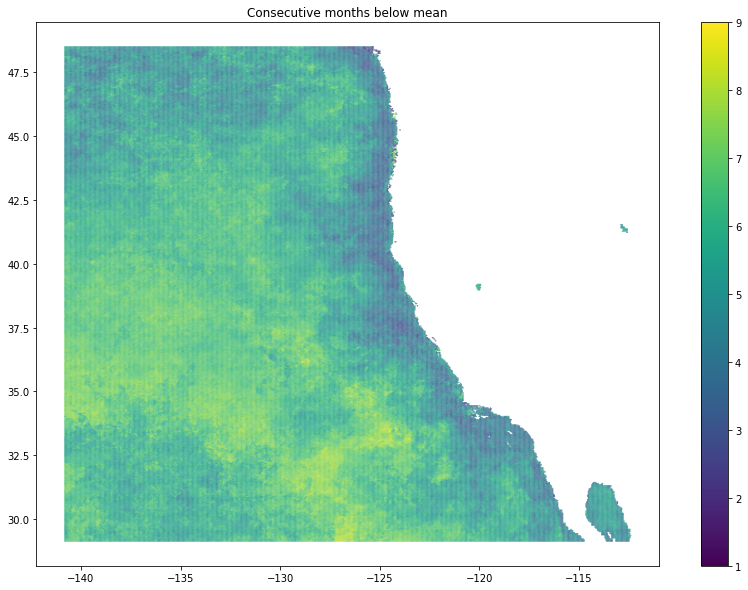

In [25]:
# Visualize
# chlorophyl - pacific mean
geometry = [Point(xy) for xy in zip(chl_summ['lon'], chl_summ['lat'])]
gp = gpd.GeoDataFrame(chl_summ, crs=geo_crs, geometry=geometry)
gp = gp.loc[gp.pacific]
fig,ax = plt.subplots(figsize=(15,10))
gp.plot(ax=ax, column='months_below_mean', markersize=0.1, legend=True)
plt.title('Consecutive months below mean')
plt.show()

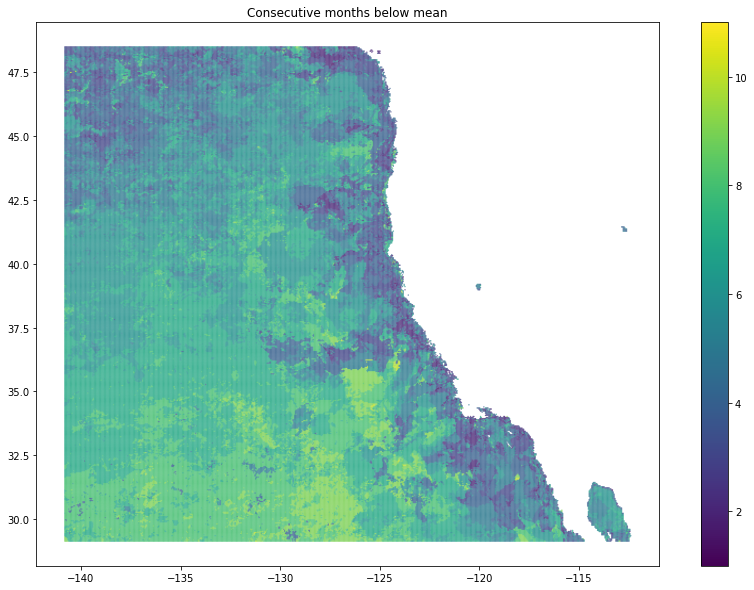

In [51]:
# Visualize
# chlorophyl - pacific mean
chl_yr = chl_summ_annual.loc[chl_summ_annual.year == 2016]
geometry = [Point(xy) for xy in zip(chl_yr['lon'], chl_yr['lat'])]
gp = gpd.GeoDataFrame(chl_yr, crs=geo_crs, geometry=geometry)
gp = gp.loc[gp.pacific]
fig,ax = plt.subplots(figsize=(15,10))
gp.plot(ax=ax, column='months_below_mean', markersize=0.1, legend=True)
plt.title('Consecutive months below mean')
plt.show()

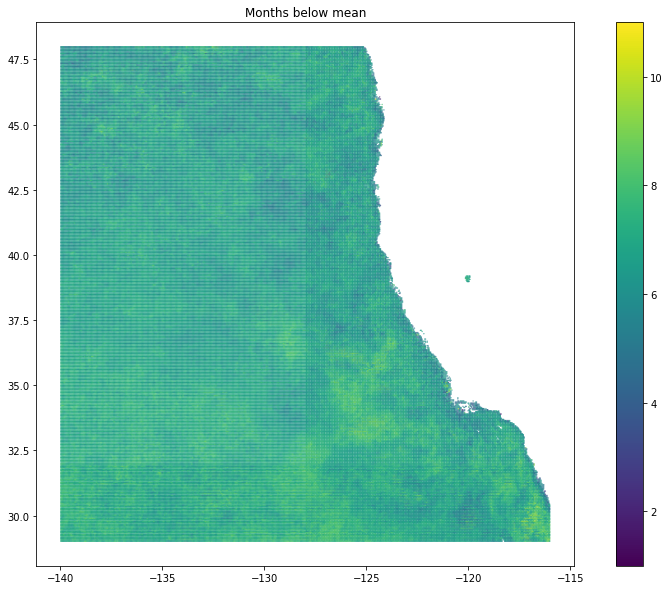

In [24]:
# Visualize
# chlorophyl - pacific mean
geometry = [Point(xy) for xy in zip(chl_summ['lon'], chl_summ['lat'])]
gp = gpd.GeoDataFrame(chl_summ, crs=crs, geometry=geometry)
gp = gp.loc[gp.pacific]
fig,ax = plt.subplots(figsize=(15,10))
gp.plot(ax=ax, column='below_mean', markersize=0.1, legend=True)
plt.title('Months below mean')
plt.show()

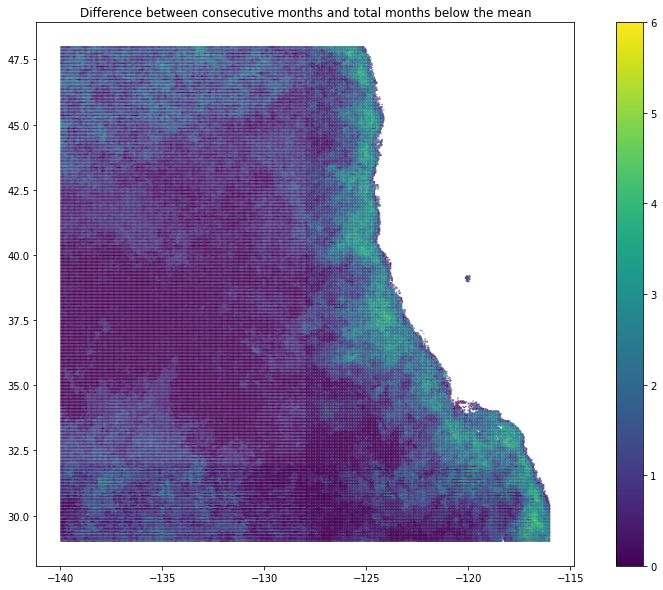

In [25]:
# Visualize
# chlorophyl - pacific mean
geometry = [Point(xy) for xy in zip(chl_summ['lon'], chl_summ['lat'])]
gp = gpd.GeoDataFrame(chl_summ, crs=crs, geometry=geometry)
gp = gp.loc[gp.pacific]
fig,ax = plt.subplots(figsize=(15,10))
gp.plot(ax=ax, column='bimodal_chl', markersize=0.1, legend=True)
plt.title('Difference between consecutive months and total months below the mean')
plt.show()

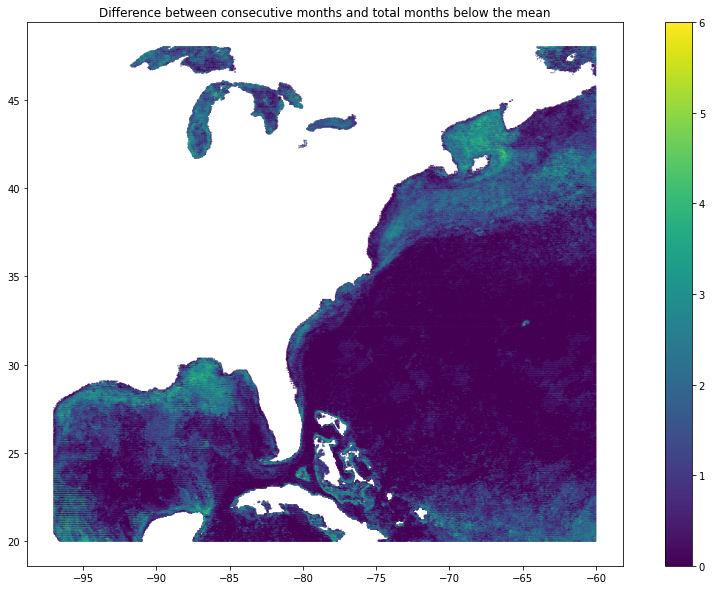

In [26]:
# Visualize
# chlorophyl - atlantic mean
geometry = [Point(xy) for xy in zip(chl_summ['lon'], chl_summ['lat'])]
gp = gpd.GeoDataFrame(chl_summ, crs=crs, geometry=geometry)
gp = gp.loc[~gp.pacific]
fig,ax = plt.subplots(figsize=(15,10))
gp.plot(ax=ax, column='bimodal_chl', markersize=0.1, legend=True)
plt.title('Difference between consecutive months and total months below the mean')
plt.show()